<a href="https://colab.research.google.com/github/sayevvv/PBL_MoneyClassification/blob/main/PBL_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# -----------------------------------------------------
# LANGKAH 1: IMPORT LIBRARY DAN MOUNT DRIVE
# -----------------------------------------------------
import os
import joblib
import numpy as np
from google.colab import drive

# Import dari Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# -----------------------------------------------------
# LANGKAH 2: KONFIGURASI DAN LOAD DATA
# -----------------------------------------------------

# Path tempat Anda menyimpan file .joblib
# Sesuai dengan skrip preprocessing
BASE_DIR = '/content/drive/MyDrive/tugas_akhir_semester5/raw_data'
PATH_X = os.path.join(BASE_DIR, 'features_X.joblib')
PATH_Y = os.path.join(BASE_DIR, 'labels_y.joblib')

print("Memuat data yang telah diproses...")

# Cek apakah file ada
if not os.path.exists(PATH_X) or not os.path.exists(PATH_Y):
    print(f"Error: File 'features_X.joblib' atau 'labels_y.joblib' tidak ditemukan di {BASE_DIR}")
    print("Pastikan Anda sudah menjalankan skrip preprocessing terlebih dahulu.")
else:
    X = joblib.load(PATH_X)
    y = joblib.load(PATH_Y)

    print(f"Data berhasil dimuat.")
    print(f"Bentuk (shape) X: {X.shape}")
    print(f"Bentuk (shape) y: {y.shape}")

Memuat data yang telah diproses...
Data berhasil dimuat.
Bentuk (shape) X: (1651, 436)
Bentuk (shape) y: (1651,)


In [7]:
# -----------------------------------------------------
# LANGKAH 3: ENCODE LABEL DAN BAGI DATA
# -----------------------------------------------------

# Model ML memerlukan angka, bukan string '1000', '2000'
# Kita gunakan LabelEncoder untuk mengubahnya (misal: '1000' -> 0, '2000' -> 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Simpan nama kelas untuk laporan nanti
class_names = le.classes_
print(f"\nLabel berhasil di-encode. Kelas: {class_names}")

# Bagi data menjadi training (80%) dan testing (20%)
# stratify=y_encoded memastikan proporsi kelas di train dan test sama
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,    # 20% untuk data tes
    random_state=42,  # Agar hasil pembagian selalu sama
    stratify=y_encoded
)

print(f"Data dibagi:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Label berhasil di-encode. Kelas: ['1000' '10000' '100000' '2000' '20000' '5000' '50000']
Data dibagi:
X_train shape: (1320, 436)
X_test shape: (331, 436)
y_train shape: (1320,)
y_test shape: (331,)


In [10]:
# -----------------------------------------------------
# LANGKAH 4: PREPROCESSING MODEL (SCALING)
# -----------------------------------------------------

# Ini langkah WAJIB untuk SVM
print("\nMelakukan StandardScaler...")
scaler = StandardScaler()

# PENTING: .fit_transform() HANYA pada X_train
# Kita "belajar" rata-rata dan std dev dari data latih
X_train_scaled = scaler.fit_transform(X_train)

# PENTING: .transform() pada X_test
# Kita menggunakan rata-rata dan std dev dari data latih
# untuk mentransformasi data tes
X_test_scaled = scaler.transform(X_test)

print("Scaling selesai.")

# Simpan scaler ini! Anda akan membutuhkannya untuk aplikasi Flask
scaler_path = os.path.join(BASE_DIR, 'svm_scaler.joblib')
joblib.dump(scaler, scaler_path)
print(f"Scaler disimpan di: {scaler_path}")


Melakukan StandardScaler...
Scaling selesai.
Scaler disimpan di: /content/drive/MyDrive/tugas_akhir_semester5/raw_data/svm_scaler.joblib


In [12]:
# -----------------------------------------------------
# LANGKAH 5: HYPERPARAMETER TUNING (GRIDSEARCHCV)
# -----------------------------------------------------
# Ini akan mencari parameter terbaik untuk SVM
# Mungkin memakan waktu beberapa menit

print("\nMemulai Hyperparameter Tuning dengan GridSearchCV...")
print("Ini mungkin memakan waktu beberapa menit...")

# Tentukan parameter yang ingin diuji
# C: Mengontrol margin. Nilai kecil = margin lebar, Nilai besar = margin sempit
# gamma: Mengontrol seberapa jauh pengaruh satu data latih
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf'] # Kernel 'rbf' (Radial Basis Function) paling umum
}

# cv=3 artinya 3-fold cross-validation
# n_jobs=-1 menggunakan semua CPU yang ada
grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=2, cv=3, n_jobs=-1)

# Latih GridSearchCV pada data yang sudah di-scaling
grid.fit(X_train_scaled, y_train)


Memulai Hyperparameter Tuning dengan GridSearchCV...
Ini mungkin memakan waktu beberapa menit...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)


Tuning selesai!
Parameter terbaik yang ditemukan: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

--- Laporan Klasifikasi SVM ---
              precision    recall  f1-score   support

        1000       0.98      1.00      0.99        48
       10000       1.00      0.94      0.97        48
      100000       0.96      0.98      0.97        48
        2000       0.98      0.98      0.98        48
       20000       1.00      1.00      1.00        48
        5000       0.96      0.98      0.97        45
       50000       1.00      1.00      1.00        46

    accuracy                           0.98       331
   macro avg       0.98      0.98      0.98       331
weighted avg       0.98      0.98      0.98       331

Akurasi Keseluruhan: 98.19%

--- Confusion Matrix ---


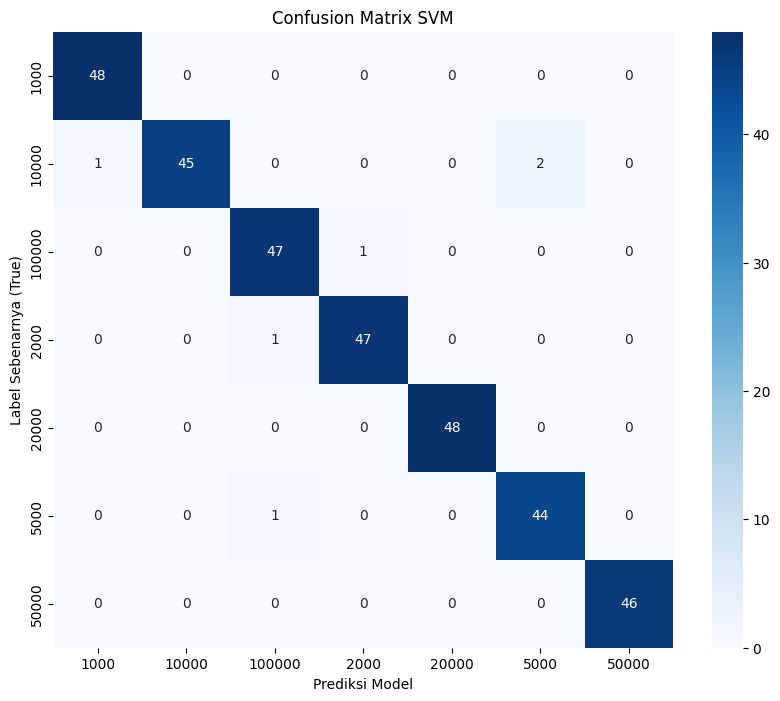

In [14]:
# -----------------------------------------------------
# LANGKAH 6: EVALUASI MODEL
# -----------------------------------------------------

print("\nTuning selesai!")

# Tampilkan parameter terbaik yang ditemukan
print(f"Parameter terbaik yang ditemukan: {grid.best_params_}")

# 'grid' sekarang adalah model SVM terbaik Anda
best_svm = grid.best_estimator_

# Lakukan prediksi pada data tes yang sudah di-scaling
y_pred = best_svm.predict(X_test_scaled)

# Tampilkan laporan evaluasi
print("\n--- Laporan Klasifikasi SVM ---")
print(classification_report(y_test, y_pred, target_names=class_names))

# Tampilkan akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Keseluruhan: {accuracy * 100:.2f}%")

# Tampilkan Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya (True)')
plt.title('Confusion Matrix SVM')
plt.show()

In [15]:

    # -----------------------------------------------------
    # LANGKAH 7: SIMPAN MODEL SVM TERLATIH
    # -----------------------------------------------------

    model_path = os.path.join(BASE_DIR, 'svm_model.joblib')
    joblib.dump(best_svm, model_path)

    print(f"\nModel SVM terbaik berhasil disimpan di: {model_path}")
    print("Proses selesai.")


Model SVM terbaik berhasil disimpan di: /content/drive/MyDrive/tugas_akhir_semester5/raw_data/svm_model.joblib
Proses selesai.
